# 13. QLS - Maximum Likelihood Estimation

## Maximum Likelihood Estimates (MLEs)

Here we'll:

1. Compute the MLE for a normal distribution.
2. Compute the MLE for an exponential distribution.
3. Fit a normal distribution to asset returns using MLE.

First, we need to import some libraries.

In [1]:
import math
import numpy as np
import scipy.stats
import seaborn as sb
sb.set(rc={'figure.figsize':(11.7,8.27)})
sb.set_style("whitegrid", {"grid.color":".6", "grid.linestyle":":"})
import yfinance as yf

### Normal Distribution

We'll start by sampling some data from a normal distribution.

In [2]:
TRUE_MEAN = 40
TRUE_STD = 10
X = np.random.normal(TRUE_MEAN, TRUE_STD, 1000)

Now we'll define functions that, given our data, will compute the MLE for the $\mu$ and $\sigma$ parameters of the normal distribution. We define that as:

$$\hat{\mu} = \frac{1}{T} \sum_{t=1}^{T} x_{t}$$

$$\hat{\sigma} = \sqrt{\frac{1}{T} \sum_{t=1}^{T}(x_{t} - \hat{\mu})^{2}}$$

In [3]:
def normal_mu_mle(x):
    # get the number of observations
    t = len(x)
    # sum the observations
    s = sum(x)
    return 1.0/t * s

def normal_sigma_mle(x):
    t = len(x)
    # get the mu MLE
    mu = normal_mu_mle(x)
    # sum the square of the differences
    s = sum(np.power((x - mu), 2))
    # compute σ²
    sigma_squared = 1.0/t * s
    return math.sqrt(sigma_squared)

Now let's try our functions out on our sample data and see how they compare to the built-in `np.mean` and `np.std`.

In [4]:
print("Mean Estimation")
print(normal_mu_mle(X))
print(np.mean(X))
print("Standard Deviation Estimation")
print(normal_sigma_mle(X))
print(np.std(X))

Mean Estimation
40.02518935545066
40.025189355450706
Standard Deviation Estimation
9.865503138593613
9.865503138593615


Now let's estimate both parameters at once with scipy's built-in `fit()` function.

In [5]:
mu, std = scipy.stats.norm.fit(X)
print("µ estimate:", mu)
print("σ estimate:", std)

µ estimate: 40.025189355450706
σ estimate: 9.865503138593615


Now let's plot the distribution PDF along ith the data to see how well it fits. We can do that by accessing the PDF provided in `scipy.stats.norm.pdf`.

/home/hooregi/documents/projects/quantopian_lectures/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


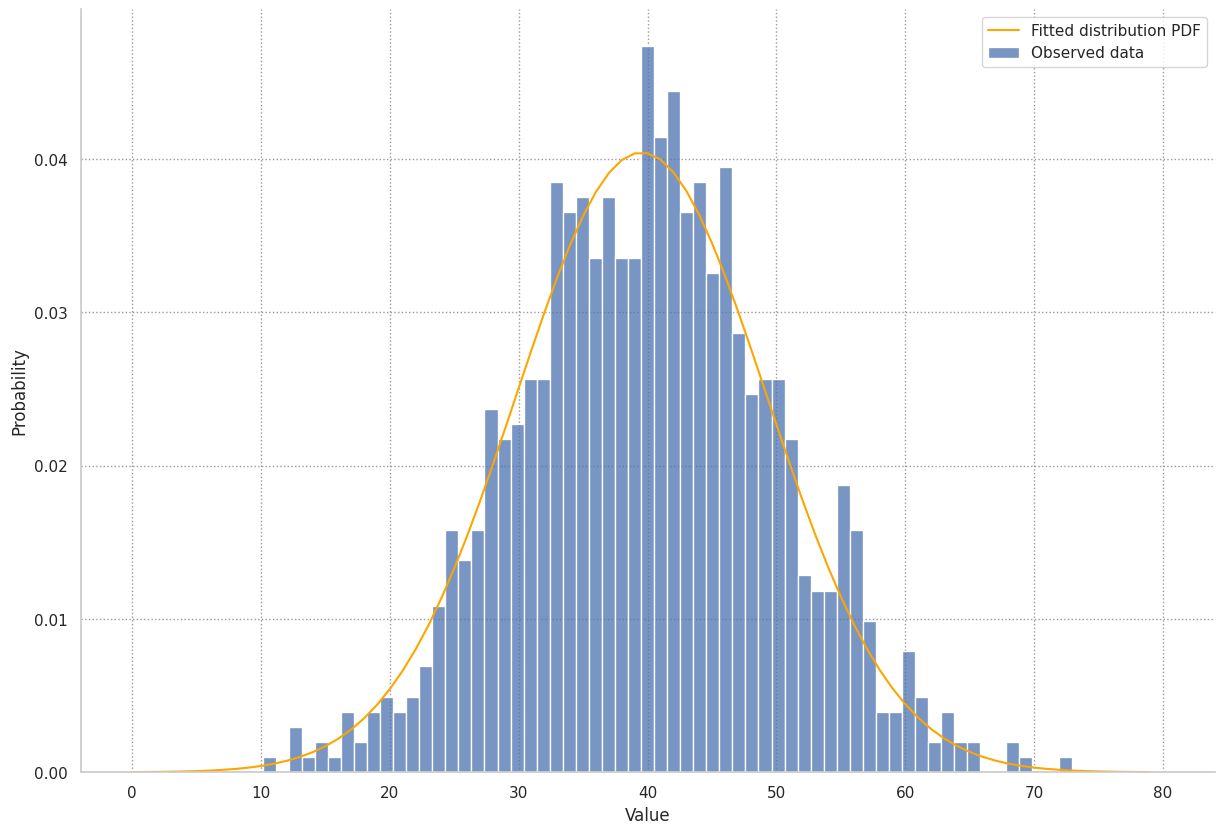

In [6]:
pdf = scipy.stats.norm.pdf
# we'd like to plot the data along an x-axis ranging from 0-80 with 80 intervals (increments of 1)
x = np.linspace(0, 80, 80)
sb.displot(X, bins=x, stat="density", label="Observed data", height=8.27, aspect=1.5)
sb.lineplot(pdf(x, loc=mu, scale=std), color="orange", label="Fitted distribution PDF").set(xlabel="Value", ylabel="Probability");

### Exponential Distribution

Let's do the same thing, but for the exponential distribution. We'll start by sampling some data.

In [7]:
TRUE_LAMBDA = 5
X = np.random.exponential(TRUE_LAMBDA, 1000)

`numpy` defines the exponential distribution as:

$$\frac{1}{\lambda} e^{- \frac{x}{\lambda}}$$

So we need to invert the MLE from before, which would be:

$$\hat{\lambda} = \frac{T}{\sum_{t=1}^{T} x_{t}}$$

Here's just the reciprocal, writen as:

$$\hat{\lambda} = \frac{\sum_{t=1}^{T} x_{t}}{T}$$

In [8]:
def exp_lambda_mle(x):
    t = len(x)
    s = sum(x)
    return s/t

In [9]:
print("λ estimate:", (exp_lambda_mle(X)))

λ estimate: 5.041822233575474


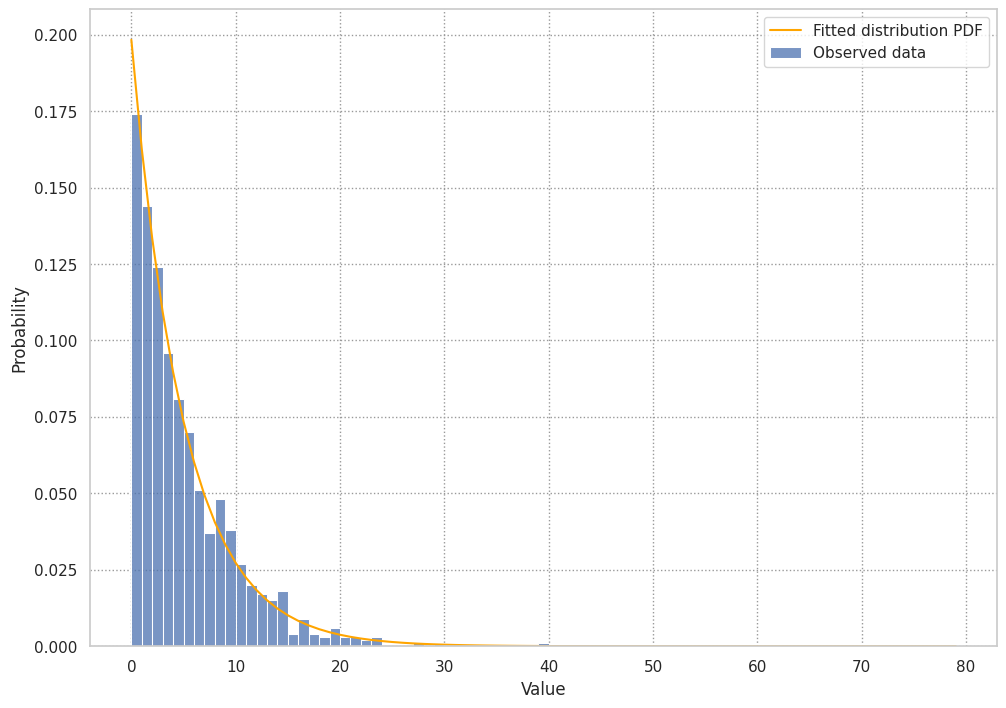

In [10]:
# scipy version of the exponential distribution has a location parameter that can skew the distribution. We ignore this by fixing the location parameter to 0 with floc=0
_, l = scipy.stats.expon.fit(X, floc=0)

pdf = scipy.stats.expon.pdf
x = range(0, 80)
sb.histplot(X, bins=x, stat="density", label="Observed data")
sb.lineplot(pdf(x, scale=l), color="orange", label="Fitted distribution PDF").set(xlabel="Value", ylabel="Probability");

## MLE For Asset Returns

Now we'll fetch some real returns and try to fit a normal distribution to them using MLE.

In [11]:
start="2014-01-01"
end="2015-01-01"
prices = yf.download("TSLA", start, end)
prices = prices["Adj Close"]
# this will give us the $ returned daily
absolute_returns = np.diff(prices)
# this will give us the % return over last day's value, the [:-1] gives us all but the last item since there are no returns in the final array
returns = absolute_returns/prices[:-1]

[*********************100%***********************]  1 of 1 completed


Let's use `scipy`'s fit function to get the $\mu$ and $\sigma$ MLEs.

/home/hooregi/documents/projects/quantopian_lectures/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


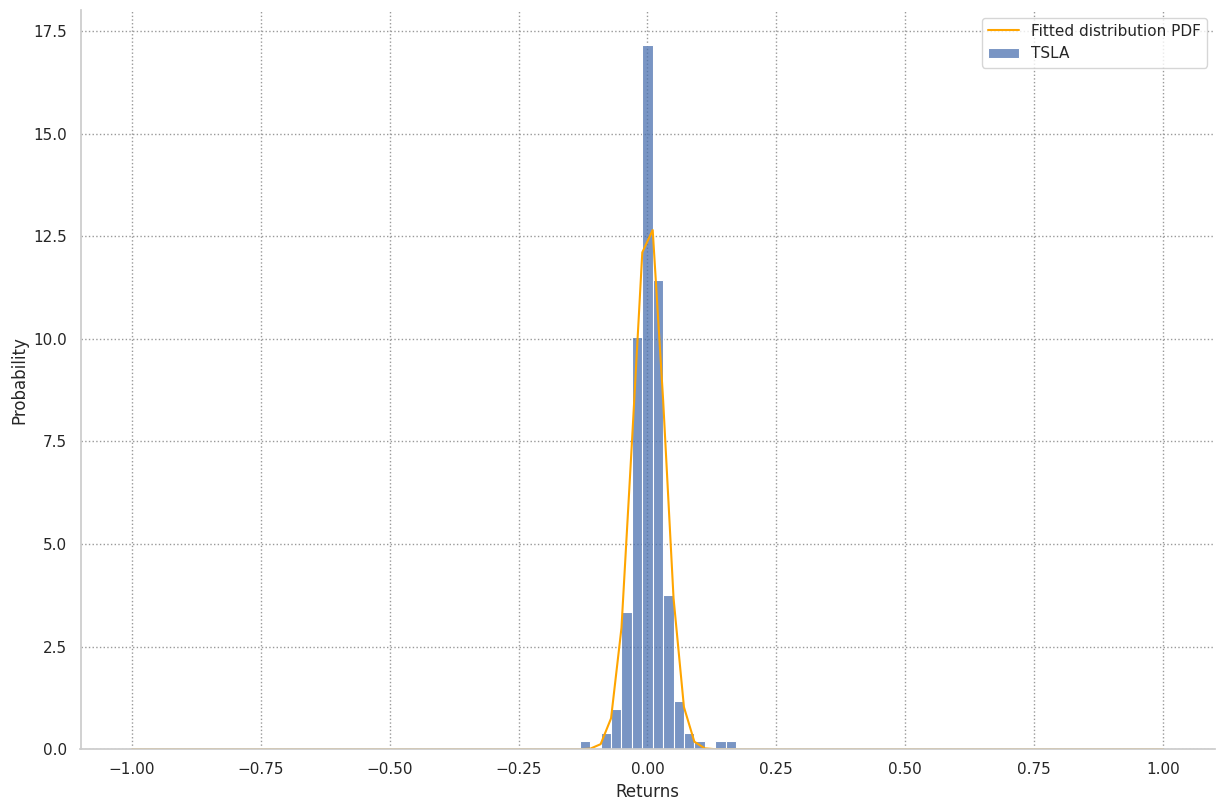

In [12]:
mu, std = scipy.stats.norm.fit(returns)
pdf = scipy.stats.norm.pdf
x = np.linspace(-1,1, num=100)
sb.displot(returns, bins=x, stat="density", label="TSLA", height=8.27, aspect=1.5)
sb.lineplot(x=x, y=pdf(x, loc=mu, scale=std), color="orange", label="Fitted distribution PDF").set(xlabel="Returns", ylabel="Probability");

Of course, this fit is meaningless unless we've tested that they obey a normal distribution. We can use the JB normality test, It'll reject the hypothesis of a normal distribution if the p-value is large.

In [13]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(returns)

(249.43268824491162,
 6.860881912969277e-55,
 0.7513123088069728,
 7.646746902938265)

In [14]:
jarque_bera(np.random.normal(0, 1, 100))

(1.8276465270153721,
 0.4009882060287626,
 0.17854009141536206,
 3.5577893056641243)